# Sentiment analysis on tweets

The goal of this project is to test the hypothesized advantages of using and fine-tuning pre-trained language models of BERT (Bidirectional Encoder Representations from Transformers), which is a 2018 paper published by researchers at Google AI Language, for financial domain. For that, sentiment of a sentence from a financial news article towards the financial actor depicted in the sentence will be tried to be predicted, using the Financial PhraseBank created by Malo et al. from Cornell University. (2014)

<table><tr><td>
<img src="./docs/bert_context.png" width="400">
</td><td>
<img src="./docs/bert_structure2.png" width="600">
</td></tr></table>

<br />
<br />

The models tested in this projects are as follows:
<br />
 * A. Lexicon-based approach (Loughran and McDonald Dictionary)
 * B. Tfidf
 * C1. LSTM (RNN)
 * C2. LSTM with GloVe word embedding
 * D1. Bert (pre-trained, hugging-face impementation)
 * D2. Albert
<br />
<br />
<br />

![All Models](./docs/all_models.png)

## Import and configurations

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [3]:
# Check the module versions
# !pip list

In [4]:
# Note: After the following pip install, you may need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install scikit-plot transformers

     |████████████████████████████████| 1.1MB 11.1MB/s 
     |████████████████████████████████| 1.1MB 25.8MB/s 
     |████████████████████████████████| 3.0MB 39.0MB/s 
     |████████████████████████████████| 890kB 38.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ec760d82b58c54c3f0fbf8279aae048c27aaf58308ab1091cb31ef4222bb9eb4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
import torch
# Check GPU Device
if IN_COLAB:
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [7]:
# Set logger
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_model_comparison_tweet', logging.DEBUG)

In [8]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [9]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [10]:
# Mount Google Drive
# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Specify file locations
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    tweet_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = './data/FinancialPhraseBank-v1.0/'
    tweet_dir = './data/tweet/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

## Evaluation Config

In [12]:
result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C1: LSTM', 'C2: LSTM+GloVe', 'D1: BERT', 'D2: ALBERT'])
result_df

,Accuracy,F1
A: Lexicon,NaN,NaN
B: Tfidf,NaN,NaN
C1: LSTM,NaN,NaN
C2: LSTM+GloVe,NaN,NaN
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [13]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

### Cross validation
Use Stratified KFold because the input data is imbalanced and better to retain the same ratio for cross validation.

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Load Input Data
Tweet data from Stocktwit

In [15]:
def load_tweet(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    with open(tweet_dir + filename, 'r') as f:
        twits = json.load(f)

    print(twits['data'][:10])
    print("The number of twits is: ", len(twits['data']))
    messages = [twit['message_body'] for twit in twits['data']]
    # Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in the network
    sentiments = [twit['sentiment'] + 2 for twit in twits['data']]
    
    print('Sample Messages: \n', messages[:10])
    return messages, sentiments

In [16]:
# Load data
filename = 'twits.json'
messages, sentiments = load_tweet(filename)

[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

## Process Input text

In [17]:
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    return text

In [18]:
# Check
test_message = 'RT @google Our annual looked at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG'
print(preprocess(test_message))

rt   our annual looked at the year in google blogging  and beyond     


In [19]:
# Process for all messages
preprocessed = [preprocess(message) for message in tqdm(messages)]

## Explore the text

In [20]:
all_words = [word for message in preprocessed for word in message.split()]
print('The number of all words: ', len(all_words))

counts = Counter(all_words)
print('The number of unique words: ', len(counts))

bow = sorted(counts, key=counts.get, reverse=True)
print('Top 40 frequent words: ', bow[:40])

The number of all words:  16553561
The number of unique words:  105899
Top 40 frequent words:  ['the', 'to', 'is', 'a', 'for', 'on', 'of', 'and', 'in', 'this', 's', 'i', 'it', 'at', 'will', 'up', 'are', 'you', 'that', 'be', 'q', 'what', 'today', 't', 'here', 'just', 'buy', 'down', 'with', 'short', 'not', 'we', 'from', 'all', 'if', 'now', 'out', 'they', 'more', 'was']


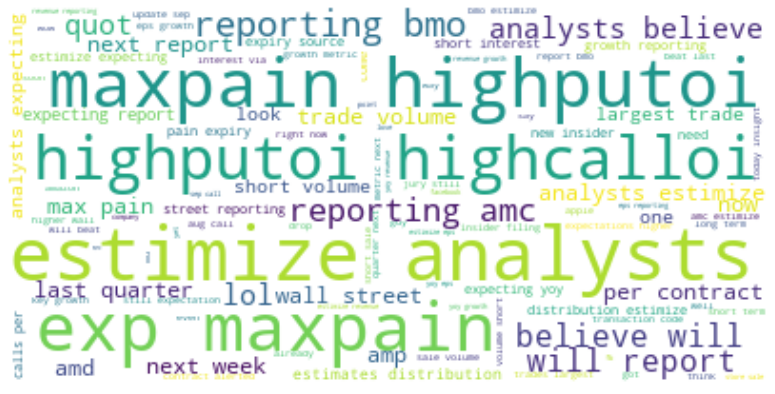

In [21]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(all_words)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=None, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
preprocessed[:2]

['  great buy at         ill wait', '   ']

In [23]:
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict)

# Ignore tweets having less than 10 words
tmp_df = tmp_df.loc[tmp_df['sentence'].apply(lambda x: len(x.split())) >= 10]
tmp_df.reset_index(drop=True, inplace=True)

# Samples
pd.set_option('display.max_colwidth', -1)
tmp_df.sample(n=20, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


,org message,sentence,label
396330,"In terms of positives for $DVN, there are 2 bullish indicators as of 08-31 https://dividendbot.com?s=DVN",in terms of positives for there are bullish indicators as of,3
340727,$INTU to give the new management team a chance to beat expectations.,to give the new management team a chance to beat expectations,3
108510,EARNING UPDATE $AXP American Express Company for quarter ending q_Jun18 - Revenue rose but Margins contracted http://abrcap.com/earning-up,earning update american express company for quarter ending q jun revenue rose but margins contracted,3
67195,$AMZN sick! they’re running a prime flash sale on shares too!,sick they re running a prime flash sale on shares too,4
135982,"$GM Now that some news about EU, will this go higher or still in the dog house?",now that some news about eu will this go higher or still in the dog house,4
62392,#FANG stocks relative to $NDX $QQQ since mid-2014. $NFLX and $AMZN don&#39;t look sustainable.,fang stocks relative to since mid and don t look sustainable,2
503461,good thing they turned on all the buy programs I thought all $FANG stocks were about to crater yesterday $FB $AAPL $NFLX $GOOG $BABA $AMZN,good thing they turned on all the buy programs i thought all stocks were about to crater yesterday,4
318002,$BTU $SO Trump Eases Coal-Pollution Curbs in Unwinding More Obama Rules via http://www.hvper.com/?ref=stw,trump eases coal pollution curbs in unwinding more obama rules via,2
172641,$AAPL has a good Piotroski-F score of 7.00. This indicates a good health and profitability. https://www.chartmill.com/analyze.php?utm_source=stocktwits&amp;utm_medium=FA&amp;utm_content=PROFITABILITY&amp;utm_campaign=social_tracking#/AAPL?r=fa&amp;key=bb853040-a4ac-41c6-b549-d218d2f21b32,has a good piotroski f score of this indicates a good health and profitability,2
280427,$MCD Trump Appointees Urged to Bow Out of McDonald&#39;s Franchisee Fight https://wallmine.com/news/16ghok/trump-appointees-urged-to-bow-out-of-mcdonald-s-franchisee-fight?utm_source=stocktwits,trump appointees urged to bow out of mcdonald s franchisee fight,2


In [24]:
# Change the table display config back
pd.set_option('display.max_colwidth', 50)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


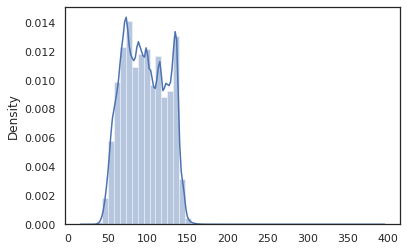

In [25]:
sns.distplot([len(x) for x in tmp_df['sentence']])

## Data Selection

The total number of data:  1548010


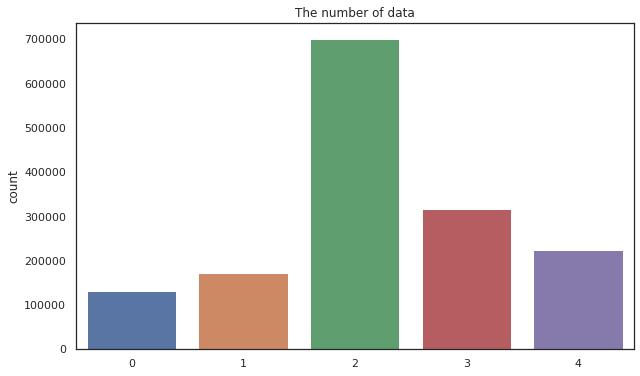

In [26]:
print("The total number of data: ", len(sentiments))
plt.figure(figsize=(10,6))
sns.countplot(x=sentiments)
plt.title('The number of data')
plt.show()

More than 60% of the data are labeled as "neutral". Sometimes imbalanced data are balanced using methods like resampling (oversampling, undersampling) as models tend to predict the majority class more. SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

Here, take label = 0, 2, 4 and balance the data using random down sampling method.

In [27]:
# Take 0, 2, 4 and update them to 0, 1, 2
train_df = tmp_df.loc[(tmp_df['label']==int(0))|(tmp_df['label']==int(2))|(tmp_df['label']==int(4))]
def update_label(x):
    if x == int(2):
        return int(1)
    elif x == int(4):
        return int(2)
    else:
        return int(0)
train_df['label'] = train_df['label'].apply(lambda x: update_label(x))

# Balancing the data
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = train_df.shape[0]

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)

balanced = {'org message': [], 'sentence': [], 'label': []}

# Keep probability
# As the negative has the least number of data, trim neutral and positive
keep_prob_neutral = n_negative/n_neutral
keep_prob_positive = n_negative/n_positive
#keep_prob = 1

for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if row['sentence'].strip() == "":
        continue
    elif (row['label'] == 0) or ((row['label'] == 1) and (random.random() < keep_prob_neutral)) or ((row['label'] == 2) and (random.random() < keep_prob_positive)):
        balanced['org message'].append(row['org message'])
        balanced['sentence'].append(row['sentence'])
        balanced['label'].append(row['label'])

train_df = pd.DataFrame(balanced)
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = len(train_df)

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)


Negative: 0.14340164994682228
Neutral:  0.6166585223298552
Positive: 0.2399398277233225
Total records:  521835


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



Negative: 0.33367518928415363
Neutral:  0.33296620976875674
Positive: 0.33335860094708963
Total records:  224266


The total number of data:  224266


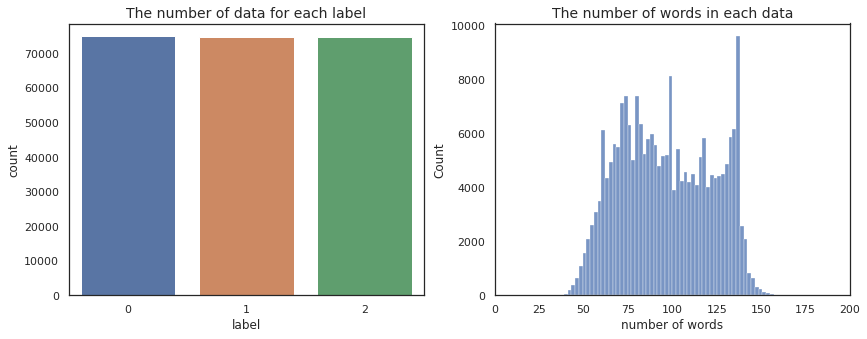

In [28]:
print("The total number of data: ", len(train_df))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)

sns.histplot([len(x) for x in train_df['sentence']], ax=ax2, bins=100)
ax2.set_title('The number of words in each data', fontsize=14)
ax2.set_xlim(0,200)
ax2.set_xlabel('number of words')
plt.show()

# A. Lexicon-based Approach

## Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use [Loughran and McDonald Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires the license to use for commercial application. Please check their website.

Download the list and save it under `lmdict_dir` as csv.

In [29]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


,sentiment,word
0,Negative,ABANDON
1,Negative,ABANDONED
2,Negative,ABANDONING
3,Negative,ABANDONMENT
4,Negative,ABANDONMENTS
...,...,...
4135,Constraining,STRICTER
4136,Constraining,STRICTEST
4137,Constraining,STRICTLY
4138,Constraining,UNAVAILABILITY


In [30]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,184
Litigious,904
Negative,2355
Positive,354
StrongModal,19
Uncertainty,297
WeakModal,27


In [31]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [32]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [33]:

# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df.head()


(224266, 3)


,org message,sentence,label,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,$GME 3% drop per week after spike... if no new...,drop per week after spike if no news i...,0,0.000000,21,0,0,[],[]
1,$SNPS short ratio is 2.17 at 2018-06-15 and sh...,short ratio is at and short ...,0,0.000000,10,0,0,[],[]
2,"$NFLX price squeezing,perfect place for an opt...",price squeezing perfect place for an option ...,2,8.333333,12,1,0,[perfect],[]
3,@DEEPAKM2013 @Nytunes Start of new Q on Monday...,start of new q on monday expect strong bu...,2,6.250000,16,1,0,[strong],[]
4,$AMZN 3 catalysts 4 Continuing this new uptren...,catalysts continuing this new uptrend ...,2,-5.882353,17,0,1,[],[break]


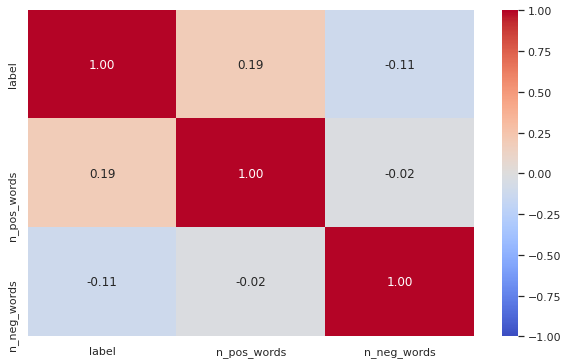

In [34]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
#corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
corr_columns = ['label', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

## Input Data

In [35]:
train_tone_df.columns

Index(['org message', 'sentence', 'label', 'tone_score', 'word_count',
       'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [36]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

## Train with different classifier

In [37]:
# Roughly check base classifiers without hyperparameter setting

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

classifiers

[('SVC',
  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, probability=False, random_state=2, shrinking=True, tol=0.001,
      verbose=False)),
 ('DecisionTree',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=2, splitter='best')),
 ('AdaBoost', AdaBoostClassifier(algorithm='SAMME.R',
                     base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                           class_weight=None,
                                                           criterion='gi

In [38]:
pd.DataFrame([rec[0] for rec in classifiers])

,0
0,SVC
1,DecisionTree
2,AdaBoost
3,RandomForest
4,ExtraTrees
5,GradientBoosting
6,MultipleLayerPerceptron
7,KNeighboors
8,LogisticRegression
9,LinearDiscriminantAnalysis


In [39]:
# cv_results = []
# classifier_name = []
# for classifier in tqdm(classifiers, desc='classifiers'):
#     cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
#     classifier_name.append(classifier[0])

# cv_acc_means = []
# cv_acc_std = []
# cv_f1_means = []
# cv_f1_std = []
# for cv_result in cv_results:
#     cv_acc_means.append(cv_result['test_accuracy'].mean())
#     cv_acc_std.append(cv_result['test_accuracy'].std())
#     cv_f1_means.append(cv_result['test_f1_macro'].mean())
#     cv_f1_std.append(cv_result['test_f1_macro'].std())

# cv_res = pd.DataFrame({"Algorithm": classifier_name,
#                        "CVAccMeans":cv_acc_means,
#                        "CVAccErrors": cv_acc_std,
#                        "CVf1Means":cv_f1_means,
#                        "CVf1Errors": cv_f1_std})

# cv_res.sort_values(by='CVAccMeans', ascending=False)

In [40]:
# # Accuracy Score Graph
# plt.figure(figsize=(18,10))
# ax = sns.barplot("CVAccMeans","Algorithm",data=cv_res.sort_values(by='CVAccMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
# ax.set_xlabel("Mean Accuracy", size=16)
# ax.set_title("Cross validation scores", size=20)

In [41]:
# # F1 Score Graph
# plt.figure(figsize=(18,10))
# ax = sns.barplot("CVf1Means","Algorithm",data=cv_res.sort_values(by='CVf1Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
# ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
# ax.set_title("Cross validation scores", size=20)

## Train with Grid Search Cross Validation

In [42]:
# Train and visualisation Function

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Negative', 'Neutral', 'Positive']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


Fitting 1 folds for each of 480 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  9.7min finished


Best Score:  0.3905277986831581
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1}


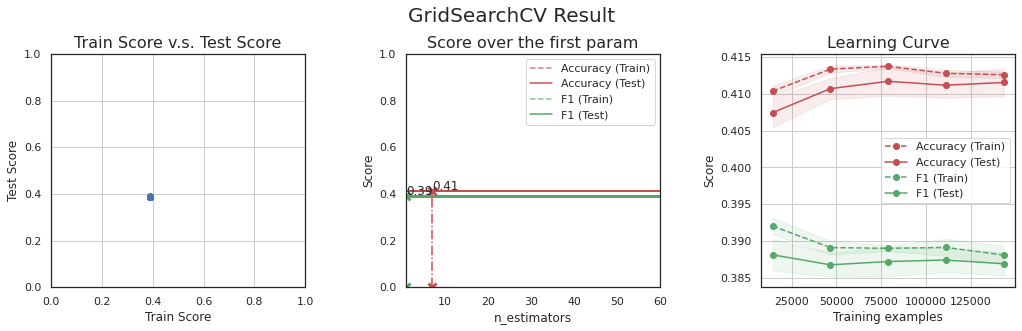

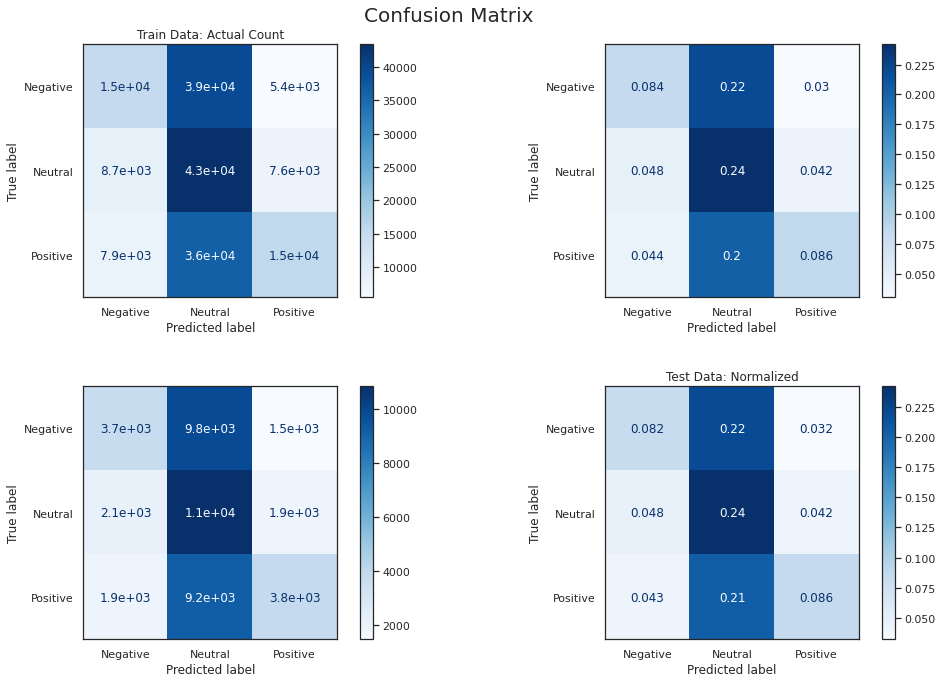

In [43]:
# Use Random Forest Classifier
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

# Do not use cross validation
nocv=[(slice(None), slice(None))]

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=nocv, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## Result
The prediction is not good at all. Hyper parameter tuning of Random Forest could not beat the simple model of Linear Discriminant Analysis. 
Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

In [44]:
pred_test = rf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['A: Lexicon'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.4101,0.3854
B: Tfidf,NaN,NaN
C1: LSTM,NaN,NaN
C2: LSTM+GloVe,NaN,NaN
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


Text(0.5, 1.0, 'Feature importance')

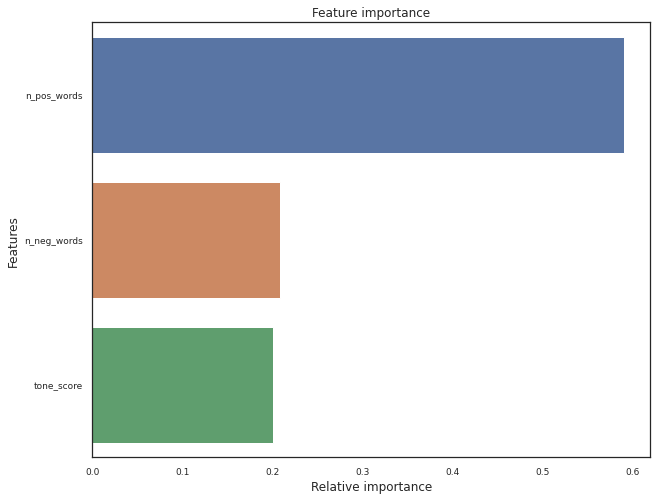

In [45]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


# B. Tfidf

### Tokenizer

In [46]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


In [47]:
# Lemmatize sentiment (not used)

# # pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# # sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# # Lemmertize sentiment words as well
# lemma_sentiment_df = sentiment_df.copy(deep=True)
# lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# # Drop duplicates
# lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# # Sentiment list
# lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

# lemma_sentiment_df.groupby(by=['sentiment']).count()

## Tokenise input texts

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


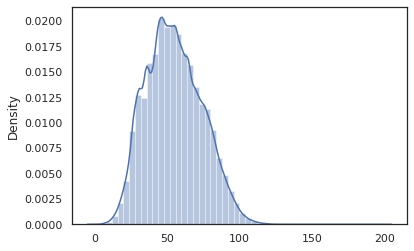

In [48]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')
sns.distplot([len(x) for x in tokenized_text])


In [49]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

## Model and Train (Logistic Regression)


In [122]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Model and Train (Random Forest)

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Do not use cross validation
nocv=[(slice(None), slice(None))]

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

tfidf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=nocv, verbose=1, plot=True)
tfidf_best = tfidf_model.best_estimator_

Fitting 1 folds for each of 20 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 92.6min finished


Best Score:  0.9968215294009798
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 200}


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


## Result
Much better than lexicon approach. Apparently it overfitting to the training set.

In [ ]:
pred_test = tfidf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['B: Tfidf'] = (round(acc,4), round(f1,4))
result_df

# C1. LSTM (RNN)
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<table><tr><td><img src="./docs/lstm_4.png" width=450></td><td><img src="./docs/lstm_1.png" width=300></td></tr></table>


In [42]:
# Import Pytorch modules
# import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW

### Tokenise input texts

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


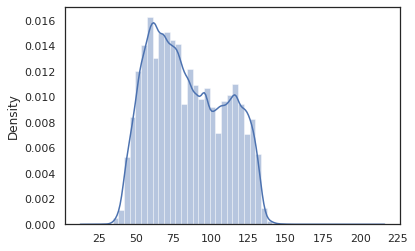

In [51]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')
sns.distplot([len(x) for x in tokenized_text])


In [52]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_tone_df['label']
X_data = token_ids

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

### Define Model
#### Embed -> RNN -> Dense -> Softmax

In [53]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

Here, I used own dataloader. It's also fine to use tensorflow/keras or pytorch implementation.

In [54]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [55]:
# Test the model
text_batch, labels = next(iter(dataloader(X_train, y_train)))
lstm_model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = lstm_model.init_hidden(16)
logps, hidden = lstm_model.forward(text_batch, hidden)
print(logps)

tensor([[-1.1086, -1.0277, -1.1643],
        [-1.1167, -1.0153, -1.1701],
        [-1.1343, -1.0149, -1.1523],
        [-1.1310, -1.0366, -1.1313],
        [-1.1092, -1.0147, -1.1788],
        [-1.1208, -1.0355, -1.1428],
        [-1.1314, -1.0308, -1.1372],
        [-1.1619, -1.0086, -1.1320],
        [-1.1272, -1.0230, -1.1503],
        [-1.1234, -1.0222, -1.1551],
        [-1.1272, -1.0211, -1.1524],
        [-1.1170, -1.0204, -1.1638],
        [-1.1172, -1.0171, -1.1674],
        [-1.1319, -1.0137, -1.1562],
        [-1.1422, -1.0187, -1.1400],
        [-1.1104, -1.0265, -1.1638]], grad_fn=<LogSoftmaxBackward>)


### Configure the model and train!

In [56]:
# Define the training process

def train_lstm_model(lstm_model, X_train, y_train, X_valid, y_valid, epochs, batch_size, learning_rate, sequence_length, patience, clip, print_every, print_epoch):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize Model
    lstm_model.embedding.weight.data.uniform_(-1, 1)
    lstm_model.to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    lstm_model.train()

    # Initialise
    accuracy = []
    f1_score = []
    best_f1, early_stop = 0, 0
    
    class_names = ['Negative', 'Neutral', 'Positive']


    # Validation steup
    def do_vadalition(valid_hidden):
        lstm_model.eval()
        valid_losses = []
        y_predicted = []
        y_truth = []
        # valid_hidden = lstm_model.init_hidden(batch_size)

        for text_batch, labels in dataloader(
                X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Initialize within the loop to use label shape if batch_size did not work
            # valid_hidden = lstm_model.init_hidden(labels.shape[0])

            # Creating new variables for the hidden state
            valid_hidden = tuple([each.data for each in valid_hidden])

            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in valid_hidden:
                each.to(device)

            # Get output and hidden state from the model
            valid_output, _ = lstm_model(text_batch, valid_hidden)

            # Calculate the loss     
            valid_loss = criterion(valid_output.squeeze(), labels)
            valid_losses.append(valid_loss.item())

            # Prediction
            ps = torch.exp(valid_output)
            top_p, top_class = ps.topk(1, dim=1)
            # equals = top_class == labels.view(*top_class.shape)
            # accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

            y_predicted.extend(top_class.squeeze().cpu().numpy())
            y_truth.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

        lstm_model.train()

        return y_truth, y_predicted, valid_losses

    # Training cycle
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # print('Starting epoch {}'.format(epoch + 1))
        hidden = lstm_model.init_hidden(batch_size)
        steps = 0

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            lstm_model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = lstm_model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                y_truth, y_predicted, valid_losses = do_vadalition(hidden)
                acc, f1 = metric(y_truth, y_predicted)
                print("Epoch: {}/{}".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))

        # End of epoch evaluation
        y_truth, y_predicted, valid_losses = do_vadalition(hidden)
        acc, f1 = metric(y_truth, y_predicted)
        
        if print_epoch:
            print("Completed {} steps in epoch {}".format(steps, epoch+1))
            

            # Plot Confusion Matrix
            y_truth_class = [class_names[int(idx)] for idx in y_truth]
            y_predicted_class = [class_names[int(idx)] for idx in y_predicted]
            
            titles_options = [("Actual Count", None), ("Normalised", 'true')]
            for title, normalize in titles_options:
                disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title)
            plt.show()

            print("\nEpoch: %d, Accuracy: %.8f, F1: %.8f\n" % (epoch+1, acc, f1))

        # If not improving, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
        else:
            early_stop += 1
                
        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

    # Post process
    y_truth, y_predicted, valid_losses = do_vadalition(hidden)
    acc, f1 = metric(y_truth, y_predicted)
    print("Completed all epochs")
    print("Accuracy: %.8f, F1: %.8f" % (acc, f1))

    return acc, f1

In [58]:
# Set Hyperparameters

# for Training
epochs=5
batch_size=64
learning_rate=3e-4
sequence_length=96
dropout=0.1
patience=3
clip=5
print_every=1000
print_epoch=True

# Model parameters
embed_size=512
lstm_size=128
dense_size=0
lstm_layers=2

########## STARTING FOLD 1 ##########


Epoch: 1/5 Step: 1000... Loss: 0.387800 Val Loss: 0.449298 Accuracy: 0.829492 F1 Score: 0.829753
Epoch: 1/5 Step: 2000... Loss: 0.522028 Val Loss: 0.369710 Accuracy: 0.866044 F1 Score: 0.865278
Completed 2243 steps in epoch 1


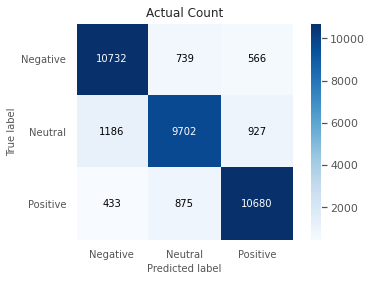

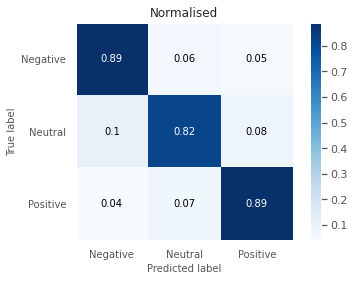


Epoch: 1, Accuracy: 0.86813616, F1: 0.86768286

Epoch: 2/5 Step: 1000... Loss: 0.199658 Val Loss: 0.340124 Accuracy: 0.877790 F1 Score: 0.877157
Epoch: 2/5 Step: 2000... Loss: 0.381533 Val Loss: 0.320240 Accuracy: 0.883343 F1 Score: 0.882758
Completed 2243 steps in epoch 2


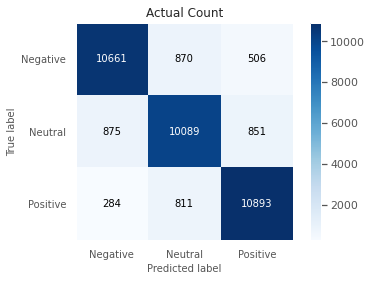

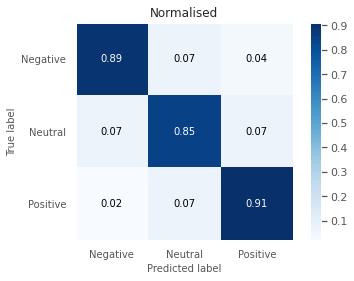


Epoch: 2, Accuracy: 0.88289621, F1: 0.88270740

Epoch: 3/5 Step: 1000... Loss: 0.126426 Val Loss: 0.321666 Accuracy: 0.887444 F1 Score: 0.886984
Epoch: 3/5 Step: 2000... Loss: 0.301394 Val Loss: 0.311159 Accuracy: 0.887667 F1 Score: 0.887218
Completed 2243 steps in epoch 3


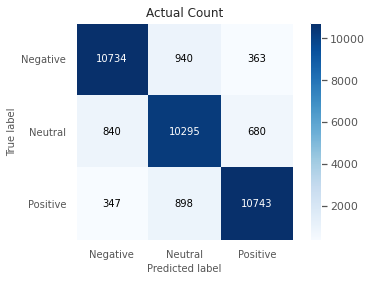

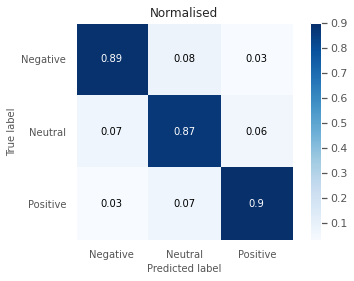


Epoch: 3, Accuracy: 0.88649554, F1: 0.88653602

Epoch: 4/5 Step: 1000... Loss: 0.117473 Val Loss: 0.335611 Accuracy: 0.889090 F1 Score: 0.888939
Epoch: 4/5 Step: 2000... Loss: 0.275382 Val Loss: 0.327695 Accuracy: 0.888839 F1 Score: 0.888602
Completed 2243 steps in epoch 4


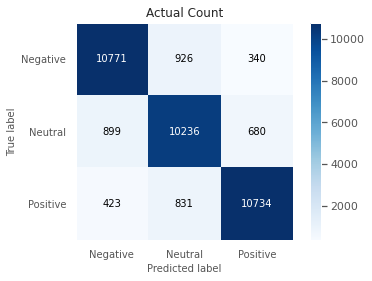

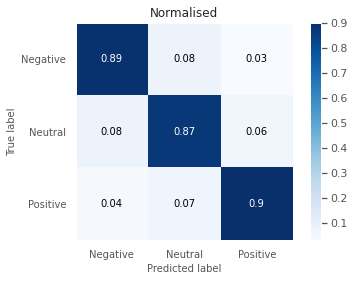


Epoch: 4, Accuracy: 0.88563058, F1: 0.88561567

Epoch: 5/5 Step: 1000... Loss: 0.128434 Val Loss: 0.347743 Accuracy: 0.887360 F1 Score: 0.887100
Epoch: 5/5 Step: 2000... Loss: 0.278070 Val Loss: 0.357248 Accuracy: 0.887333 F1 Score: 0.887115
Completed 2243 steps in epoch 5


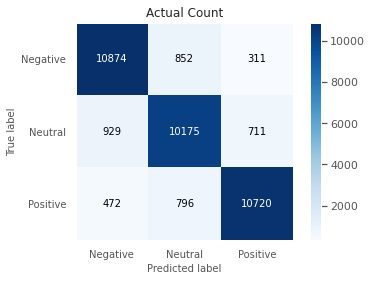

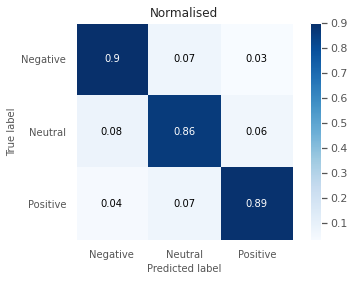


Epoch: 5, Accuracy: 0.88641183, F1: 0.88631243


Completed all epochs
Accuracy: 0.88641183, F1: 0.88631243
#################### FINAL RESULT ####################
Average Accuracy: 0.88641183, Average F1: 0.88631243


In [65]:
acc_list = []
f1_list = []
  
for fold, (train_indices, valid_indices) in enumerate(kfold.split(y_train, y_train)):
    print("########## STARTING FOLD {} ##########".format(fold+1))
    # Split to train set and validation set
    X_train_fold = np.array(X_train)[train_indices]
    y_train_fold = y_train[train_indices]
    X_valid_fold = np.array(X_train)[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Set Model
    model = TextClassifier(len(vocab)+1, embed_size, lstm_size, dense_size, 3, lstm_layers, dropout)

    # Train the model for this fold
    acc, f1 = train_lstm_model(model, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, print_every, print_epoch)

    acc_list.append(acc)
    f1_list.append(f1)

    if fold==0:
        break

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

# Save the best model
# torch.save(best_lstm_model.state_dict(), output_dir + 'finphrase_lstm_model_f{}_e{}.dict'.format(best_fold, best_epoch))

## Result

Epoch: 1/5 Step: 1000... Loss: 0.427903 Val Loss: 0.456186 Accuracy: 0.831071 F1 Score: 0.830568
Epoch: 1/5 Step: 2000... Loss: 0.277342 Val Loss: 0.381088 Accuracy: 0.861830 F1 Score: 0.861369
Completed 2804 steps in epoch 1


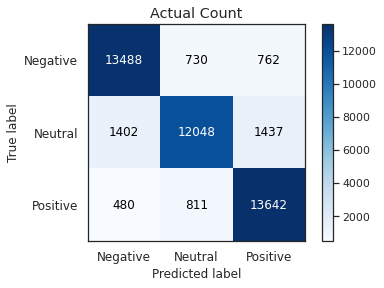

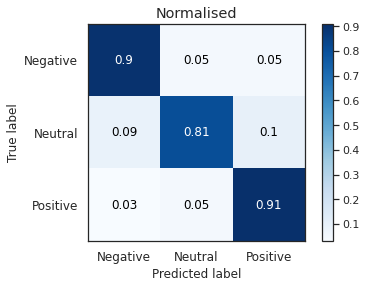


Epoch: 1, Accuracy: 0.87450893, F1: 0.87386972

Epoch: 2/5 Step: 1000... Loss: 0.267718 Val Loss: 0.327106 Accuracy: 0.880290 F1 Score: 0.879500
Epoch: 2/5 Step: 2000... Loss: 0.225775 Val Loss: 0.314204 Accuracy: 0.885536 F1 Score: 0.885063
Completed 2804 steps in epoch 2


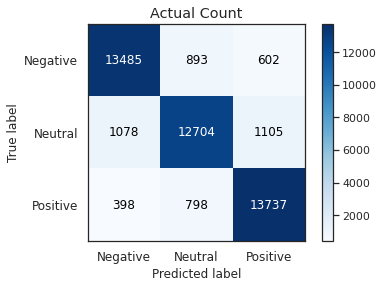

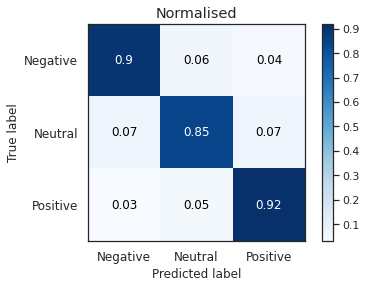


Epoch: 2, Accuracy: 0.89120536, F1: 0.89096870

Epoch: 3/5 Step: 1000... Loss: 0.208175 Val Loss: 0.298354 Accuracy: 0.890848 F1 Score: 0.890140
Epoch: 3/5 Step: 2000... Loss: 0.181196 Val Loss: 0.300064 Accuracy: 0.890402 F1 Score: 0.889883
Completed 2804 steps in epoch 3


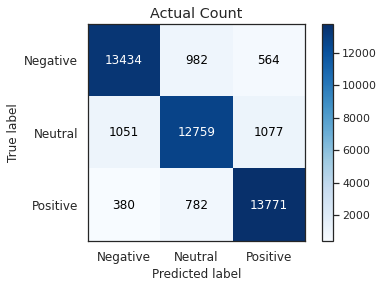

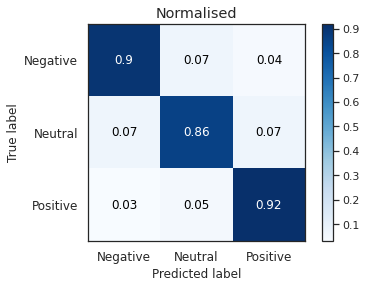


Epoch: 3, Accuracy: 0.89205357, F1: 0.89184810

Epoch: 4/5 Step: 1000... Loss: 0.221616 Val Loss: 0.298662 Accuracy: 0.894018 F1 Score: 0.893423
Epoch: 4/5 Step: 2000... Loss: 0.179702 Val Loss: 0.302522 Accuracy: 0.893013 F1 Score: 0.892526
Completed 2804 steps in epoch 4


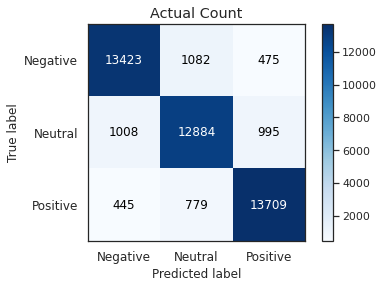

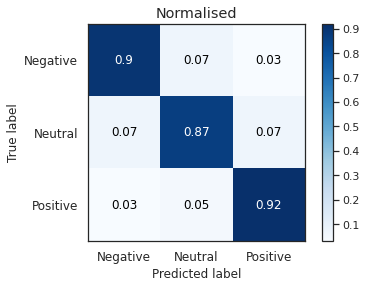


Epoch: 4, Accuracy: 0.89321429, F1: 0.89310573

Epoch: 5/5 Step: 1000... Loss: 0.207788 Val Loss: 0.317580 Accuracy: 0.891518 F1 Score: 0.890765
Epoch: 5/5 Step: 2000... Loss: 0.165153 Val Loss: 0.348768 Accuracy: 0.886629 F1 Score: 0.886464
Completed 2804 steps in epoch 5


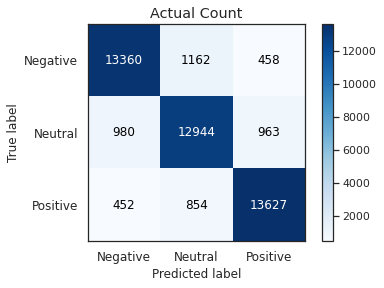

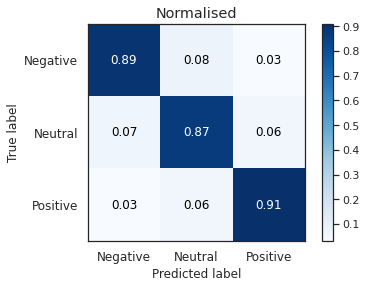


Epoch: 5, Accuracy: 0.89131696, F1: 0.89129561


Completed all epochs
Accuracy: 0.89131696, F1: 0.89129561


In [60]:
# Re-train the model with all Train set and validate on Test set

# Set Model
model = TextClassifier(len(vocab)+1, embed_size, lstm_size, dense_size, 3, lstm_layers, dropout)

acc, f1 = train_lstm_model(model, X_train, y_train, X_test, y_test, \
                         epochs, batch_size, learning_rate, sequence_length, \
                         patience, clip, print_every, print_epoch)
        

In [61]:
result_df.loc['C1: LSTM'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,NaN,NaN
B: Tfidf,NaN,NaN
C1: LSTM,0.8913,0.8913
C2: LSTM+GloVe,NaN,NaN
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


# C2. Glove Word Embedding + LSTM
Use GloVe word embedding as embedding layer

### Download GloVe files

In [66]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [67]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print("The number of words in the dict: ", len(glove_dict))
print("Embedding for the word 'the':")
glove_dict['the']

The number of words in the dict:  400000
Embedding for the word 'the':


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [68]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

32084 words found out of 45767 words in vocab.
(45768, 300)


### Define Model

In [69]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [72]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 0, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(45768, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [73]:
# Set Hyperparameters

# for Training
epochs=5
batch_size=64
learning_rate=3e-4
sequence_length=96
dropout=0.1
patience=3
clip=5
print_every=1000
print_epoch=True

# Model parameters
lstm_size=128
dense_size=0
lstm_layers=2

########## STARTING FOLD 1 ##########


Epoch: 1/5 Step: 1000... Loss: 0.591960 Val Loss: 0.549328 Accuracy: 0.778850 F1 Score: 0.778993
Epoch: 1/5 Step: 2000... Loss: 0.488234 Val Loss: 0.452460 Accuracy: 0.832366 F1 Score: 0.832339
Completed 2243 steps in epoch 1


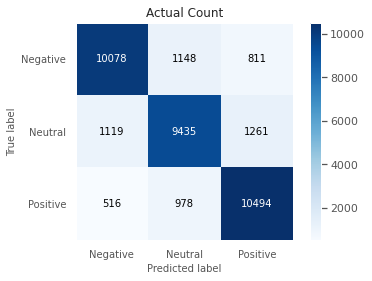

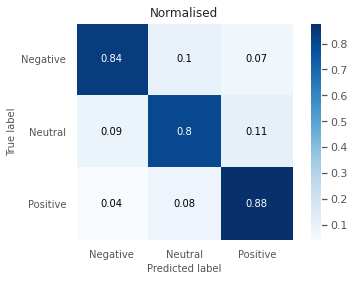


Epoch: 1, Accuracy: 0.83724888, F1: 0.83689365

Epoch: 2/5 Step: 1000... Loss: 0.354548 Val Loss: 0.398069 Accuracy: 0.853125 F1 Score: 0.852729
Epoch: 2/5 Step: 2000... Loss: 0.409141 Val Loss: 0.368474 Accuracy: 0.865485 F1 Score: 0.864887
Completed 2243 steps in epoch 2


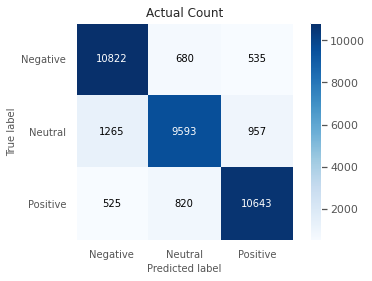

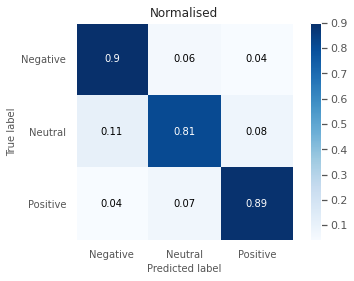


Epoch: 2, Accuracy: 0.86657366, F1: 0.86600226

Epoch: 3/5 Step: 1000... Loss: 0.252200 Val Loss: 0.361107 Accuracy: 0.870145 F1 Score: 0.869742
Epoch: 3/5 Step: 2000... Loss: 0.353367 Val Loss: 0.345470 Accuracy: 0.873214 F1 Score: 0.872546
Completed 2243 steps in epoch 3


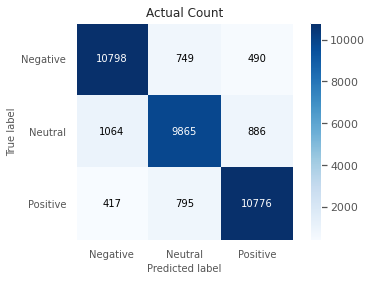

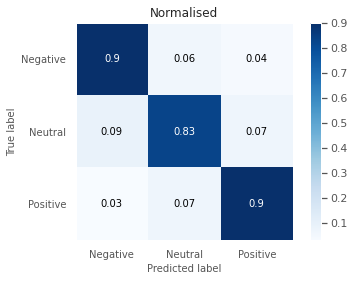


Epoch: 3, Accuracy: 0.87720424, F1: 0.87682791

Epoch: 4/5 Step: 1000... Loss: 0.212755 Val Loss: 0.347100 Accuracy: 0.877204 F1 Score: 0.876908
Epoch: 4/5 Step: 2000... Loss: 0.331958 Val Loss: 0.335377 Accuracy: 0.877148 F1 Score: 0.876763
Completed 2243 steps in epoch 4


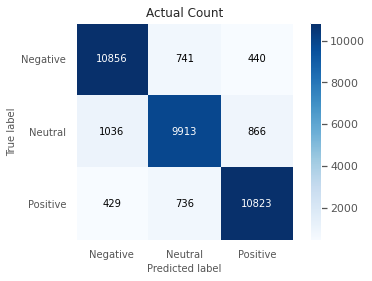

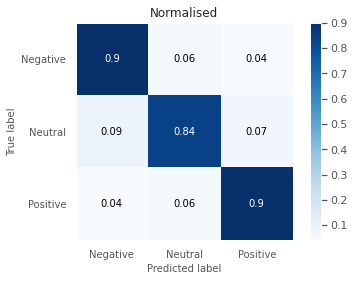


Epoch: 4, Accuracy: 0.88147321, F1: 0.88109879

Epoch: 5/5 Step: 1000... Loss: 0.179828 Val Loss: 0.349611 Accuracy: 0.880720 F1 Score: 0.880571
Epoch: 5/5 Step: 2000... Loss: 0.276901 Val Loss: 0.353314 Accuracy: 0.875474 F1 Score: 0.875210
Completed 2243 steps in epoch 5


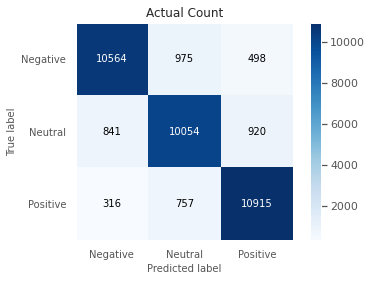

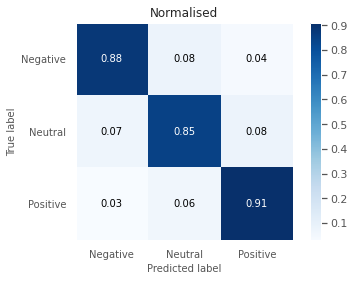


Epoch: 5, Accuracy: 0.87982701, F1: 0.87962549


Completed all epochs
Accuracy: 0.87982701, F1: 0.87962549
#################### FINAL RESULT ####################
Average Accuracy: 0.87982701, Average F1: 0.87962549


In [74]:
acc_list = []
f1_list = []
  
for fold, (train_indices, valid_indices) in enumerate(kfold.split(y_train, y_train)):
    print("########## STARTING FOLD {} ##########".format(fold+1))
    # Split to train set and validation set
    X_train_fold = np.array(X_train)[train_indices]
    y_train_fold = y_train[train_indices]
    X_valid_fold = np.array(X_train)[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Set Model
    model = GloveTextClassifier(weight_matrix, lstm_size, dense_size, 3, lstm_layers, dropout)

    # Train the model for this fold
    acc, f1 = train_lstm_model(model, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, print_every, print_epoch)

    acc_list.append(acc)
    f1_list.append(f1)

    # Stop after this fold
    if fold==0:
        break

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

# Save the best model
# torch.save(best_lstm_model.state_dict(), output_dir + 'finphrase_lstm_model_f{}_e{}.dict'.format(best_fold, best_epoch))

### Result

Epoch: 1/5 Step: 1000... Loss: 0.515004 Val Loss: 0.560569 Accuracy: 0.777746 F1 Score: 0.777112
Epoch: 1/5 Step: 2000... Loss: 0.284497 Val Loss: 0.465611 Accuracy: 0.821808 F1 Score: 0.821884
Completed 2804 steps in epoch 1


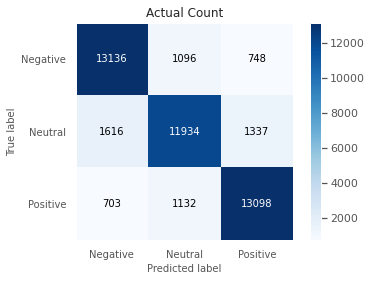

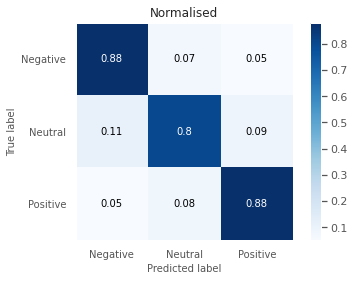


Epoch: 1, Accuracy: 0.85196429, F1: 0.85156650

Epoch: 2/5 Step: 1000... Loss: 0.311722 Val Loss: 0.378445 Accuracy: 0.862746 F1 Score: 0.862388
Epoch: 2/5 Step: 2000... Loss: 0.206827 Val Loss: 0.361859 Accuracy: 0.869442 F1 Score: 0.869082
Completed 2804 steps in epoch 2


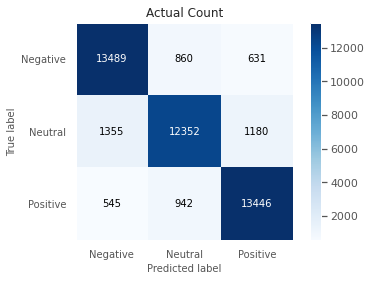

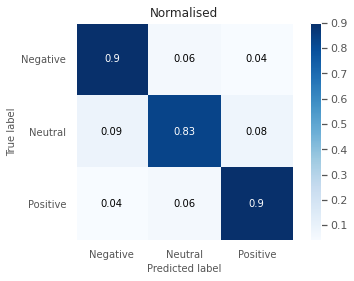


Epoch: 2, Accuracy: 0.87694196, F1: 0.87658601

Epoch: 3/5 Step: 1000... Loss: 0.276831 Val Loss: 0.334607 Accuracy: 0.881786 F1 Score: 0.881428
Epoch: 3/5 Step: 2000... Loss: 0.192815 Val Loss: 0.330883 Accuracy: 0.881272 F1 Score: 0.880905
Completed 2804 steps in epoch 3


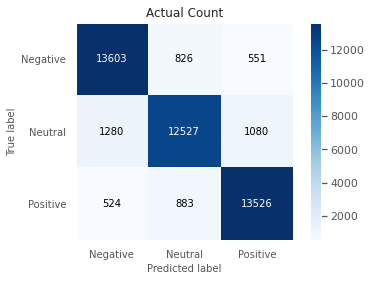

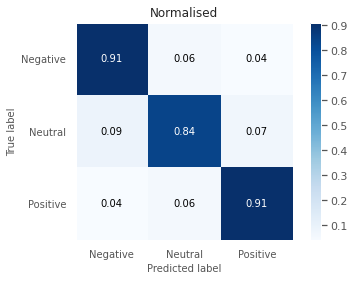


Epoch: 3, Accuracy: 0.88517857, F1: 0.88487852

Epoch: 4/5 Step: 1000... Loss: 0.219182 Val Loss: 0.318960 Accuracy: 0.886362 F1 Score: 0.885967
Epoch: 4/5 Step: 2000... Loss: 0.217846 Val Loss: 0.319697 Accuracy: 0.884955 F1 Score: 0.884619
Completed 2804 steps in epoch 4


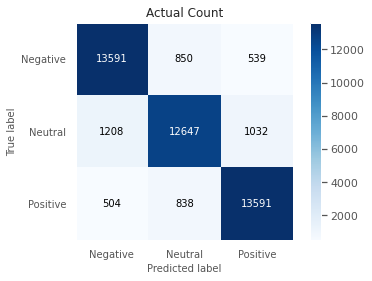

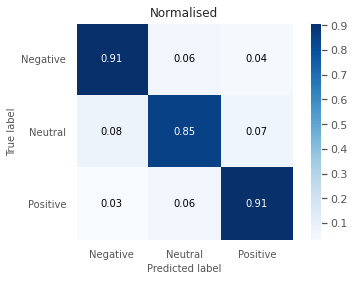


Epoch: 4, Accuracy: 0.88904018, F1: 0.88879552

Epoch: 5/5 Step: 1000... Loss: 0.217420 Val Loss: 0.310951 Accuracy: 0.889241 F1 Score: 0.888718
Epoch: 5/5 Step: 2000... Loss: 0.183777 Val Loss: 0.315561 Accuracy: 0.885982 F1 Score: 0.885570
Completed 2804 steps in epoch 5


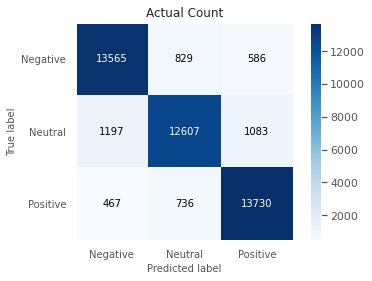

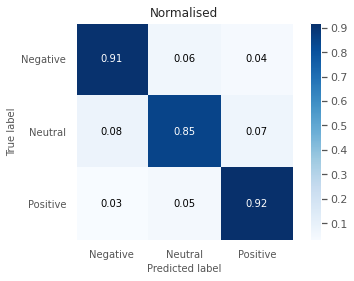


Epoch: 5, Accuracy: 0.89066964, F1: 0.89035808


Completed all epochs
Accuracy: 0.89066964, F1: 0.89035808


In [75]:
# Set Model
model = GloveTextClassifier(weight_matrix, lstm_size, dense_size, 3, lstm_layers, dropout)

# Re-train the model with all Train set and validate on Test set
acc, f1 = train_lstm_model(model, X_train, y_train, X_test, y_test, \
                         epochs, batch_size, learning_rate, sequence_length, \
                         patience, clip, print_every, print_epoch)

In [76]:
result_df.loc['C2: LSTM+GloVe'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,NaN,NaN
B: Tfidf,NaN,NaN
C1: LSTM,0.8913,0.8913
C2: LSTM+GloVe,0.8907,0.8904
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


# D1. BERT Model

<table><tr><td><img src="./docs/bert_model.png" width=400></td><td><img src="./docs/transformer.png" width=550></td></tr></table>

![Comparison](./docs/bert-vs-openai-vs-elmo.png)

### BERT Encoding

In [77]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


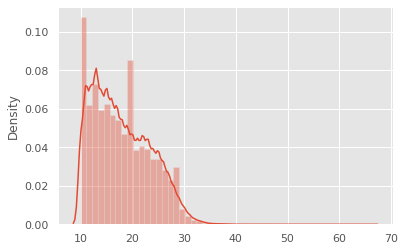

In [78]:
# Check the distribution to decide the maximum length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sns.distplot([len(tokenizer.tokenize(text)) for text in train_df['sentence']])

In [79]:
# # Define input class and bert encoder
# # Comment out this as the function is now provided by Huggingface

# class InputFeature(object):
#     """ A single training/test data class """
#     def __init__(self, id, input_ids, masks, segments, label=None):
#         self.id = id
#         self.features = {
#             'input_ids': input_ids,
#             'input_mask': masks,
#             'segment_ids': segments
#         }
#         self.label = label

# def bert_encoder(text, max_len=80):
#     """ Return embedded text vector as a list in max_len with a mask list"""
#     text_token = tokenizer.tokenize(text)
#     text_token = text_token[:max_len-2]
#     text_token = ["[CLS]"] + text_token + ["[SEP]"]
#     text_ids = tokenizer.convert_tokens_to_ids(text_token)
#     text_ids += [0] * (max_len - len(text_token))
#     pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
#     segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
#     return text_ids, pad_masks, segment_ids

In [80]:
# Define a DataSet Class which simply return (x, y) pair instead
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

### Define Bert Model

In [81]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [82]:
# Test the model and tokenizer

# Comment out here as not using own implementation
# bert_model = BertTextClassifier(768, 128, 3, dropout=0.1)
# text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
# tokenizer.encode() returns only input_ids, whereas tokenizer() returns dict

#print('text_ids: \n', text_ids)
#print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
#text_ids = torch.tensor(text_ids).unsqueeze(0)
#print('text_ids (unsqueezed): \n', text_ids)
#pad_masks = torch.tensor(pad_masks).unsqueeze(0)
#print('pad_masks: ',pad_masks)
#segment_ids = torch.tensor(segment_ids).unsqueeze(0)
#print('segment_ids: ',segment_ids)

#outputs = bert_model(text_ids)
#outputs = bert_model(text_ids, pad_masks, segment_ids)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
inputs = tokenizer("Hello, my dog is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)
print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = bert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

inputs: 
 {'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Input Data

In [83]:
# Split the data
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
test = train_df[~msk]

In [84]:
# Prepare training data
# Comment out here as not using own implementation

# train_set, test_set = [], []
# max_seq_length = 48

# for index, row in tqdm(train.iterrows(), total=train.shape[0]):
#     input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
#     train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

# train_labels = train['label'].astype(int).values

# for index, row in tqdm(test.iterrows(), total=test.shape[0]):
#     input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
#     test_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

# test_labels = test['label'].astype(int).values

# # numpy array to split train and valid within Fold later
# train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
# train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
# train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
# train_valid_labels = np.array([data.label for data in train_set])

# oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

# # test data
# test_input_ids = [data.features['input_ids'] for data in test_set]
# test_input_masks = [data.features['input_mask'] for data in test_set]
# test_segment_ids =[data.features['segment_ids'] for data in test_set]
# test_labels = [data.label for data in test_set]


### Train

In [85]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length):
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # # Train Data in Tensor
    # train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    # train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    # train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    # train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # # Validation Data in Tensor
    # valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    # valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    # valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    # valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # # Load data into TensorDataset
    # train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    # valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    print('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_HF(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    ## Set Loss Function
    ## If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    # loss_fn = torch.nn.CrossEntropyLoss()

    ## Set Optimizer
    ## Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    ## If we use torch.optim.Adam, set with parameter groups like this:
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'padding': 'max_length',
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((len(y_valid), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        # print('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in enumerate(train_loader):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = model(**x_train_bt, labels=y_train_bt)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        #valid_preds_fold = np.zeros((y_valid.size(0), 3))
        y_valid_pred = np.zeros((len(y_valid), 3))
        
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                loss, logits = model(**x_valid_bt, labels=y_valid_bt)
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
            #torch.save(model.state_dict(), output_dir + out_model_name)
        else:
            early_stop += 1
            
        print('epoch: %d, train loss: %.4f, valid loss: %.4f, acc: %.4f, f1: %.4f, best_f1: %.4f, last lr: %.6f' %
              (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    print('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o', label='Training Loss')
    plt.plot(valid_losses, 'r-o', label='Validation Loss')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    ## Load the best model
    #model.load_state_dict(torch.load(output_dir + out_model_name))
    ## Set the model to Evaluation Mode
    #model.eval()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return acc, f1, valid_best, model

In [86]:
# Hyperparameters
learning_rate = 2e-5
num_epochs = 3
batch_size = 64
patience = 2
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 96

# bert_hidden_size = 768
# bert_dense_size = 128

================     fold 1    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 6732 (2244 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.4041, valid loss: 0.2659, acc: 0.9064, f1: 0.9056, best_f1: 0.9056, last lr: 0.000015
epoch: 2, train loss: 0.2188, valid loss: 0.2414, acc: 0.9172, f1: 0.9168, best_f1: 0.9168, last lr: 0.000007
epoch: 3, train loss: 0.1710, valid loss: 0.2501, acc: 0.9183, f1: 0.9180, best_f1: 0.9180, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


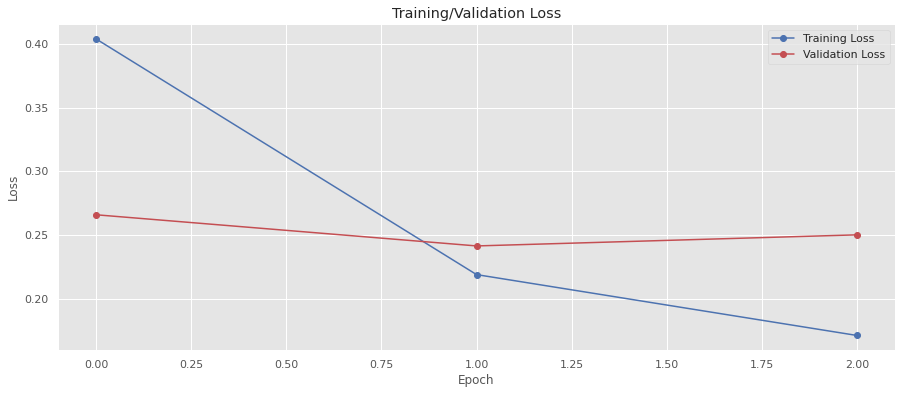

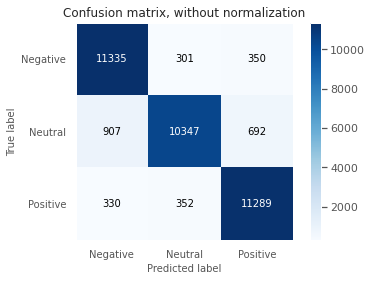

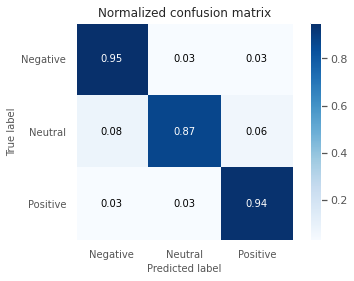

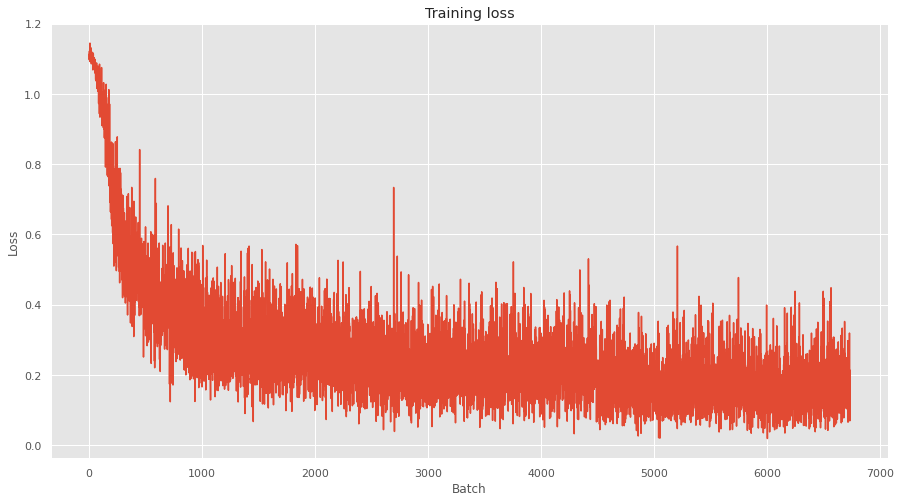

#################### FINAL RESULT ####################
Average Accuracy: 0.91833552, Average F1: 0.91801221


In [87]:
# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

acc_list, f1_list = [], []

for n_fold, (train_indices, valid_indices) in enumerate(kfold.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    acc, f1, valid_best, _ = \
        train_transformer(bert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 0:
        break

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))


## Test and Result
Make sure you do not run the test until the model is fixed by cross validation.

In [ ]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

acc, f1, valid_best, model_trained = \
        train_transformer(bert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

torch.save(model_trained.state_dict(), output_dir + 'fintweet_bert.dict')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 16812 (5604 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.3858, valid loss: 0.2515, acc: 0.9110, f1: 0.9107, best_f1: 0.9107, last lr: 0.000015
epoch: 2, train loss: 0.2170, valid loss: 0.2315, acc: 0.9197, f1: 0.9196, best_f1: 0.9196, last lr: 0.000007


In [88]:
result_df.loc['D1: BERT'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,NaN,NaN
B: Tfidf,NaN,NaN
C1: LSTM,0.8913,0.8913
C2: LSTM+GloVe,0.8907,0.8904
D1: BERT,0.9183,0.918
D2: ALBERT,NaN,NaN


# D2: ALBERT

### Model and Train

In [89]:
# Set Tokenizer and Model
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertModel
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [90]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 3
batch_size = 64
patience = 2
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 96

# bert_hidden_size = 768
# bert_dense_size = 128

================     fold 1    ===============


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 6732 (2244 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.4675, valid loss: 0.2963, acc: 0.8953, f1: 0.8950, best_f1: 0.8950, last lr: 0.000007
epoch: 2, train loss: 0.2651, valid loss: 0.2600, acc: 0.9089, f1: 0.9085, best_f1: 0.9085, last lr: 0.000004
epoch: 3, train loss: 0.2207, valid loss: 0.2561, acc: 0.9107, f1: 0.9104, best_f1: 0.9104, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


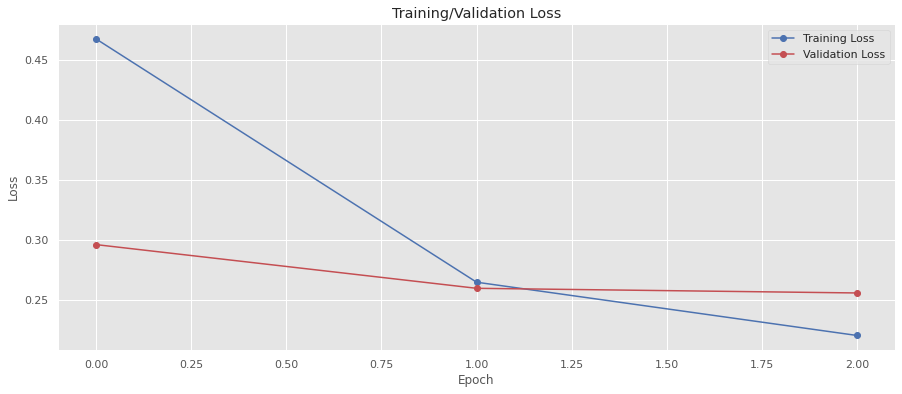

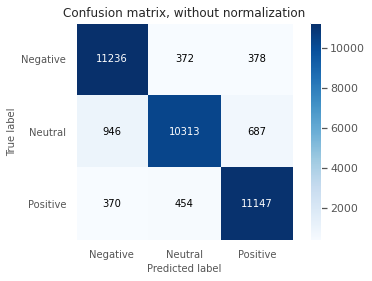

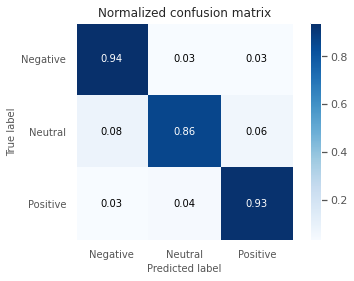

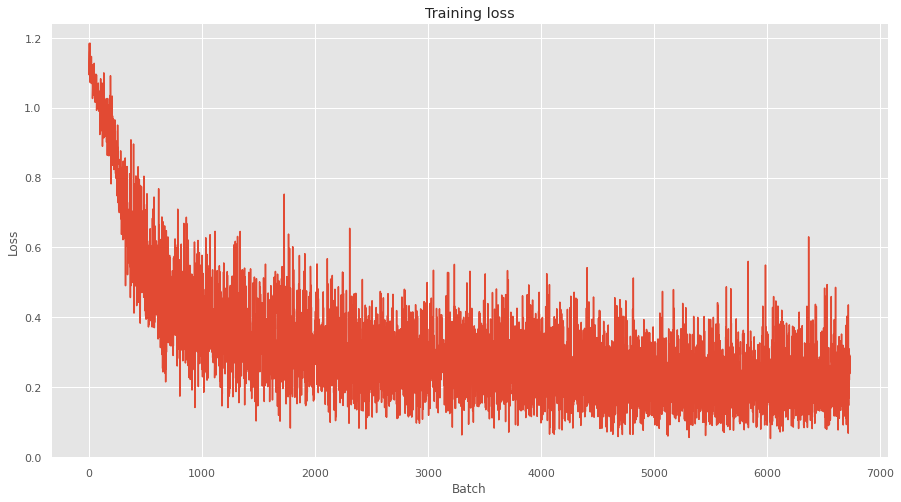

#################### FINAL RESULT ####################
Average Accuracy: 0.91067599, Average F1: 0.91039065


In [91]:
# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

acc_list, f1_list = [], []

for n_fold, (train_indices, valid_indices) in enumerate(kfold.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)
    
    acc, f1, valid_best, _ = \
        train_transformer(albert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 0:
        break


print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))


### Test and Result
Make sure you do not run the test until the model is fixed by cross validation.

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 8415 (2805 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.4377, valid loss: 0.2827, acc: 0.8961, f1: 0.8958, best_f1: 0.8958, last lr: 0.000007
epoch: 2, train loss: 0.2451, valid loss: 0.2482, acc: 0.9110, f1: 0.9105, best_f1: 0.9105, last lr: 0.000004
epoch: 3, train loss: 0.1975, valid loss: 0.2490, acc: 0.9124, f1: 0.9120, best_f1: 0.9120, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


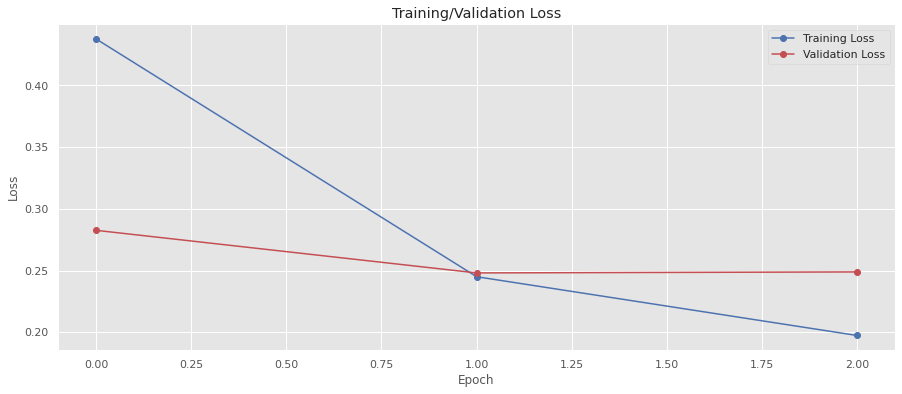

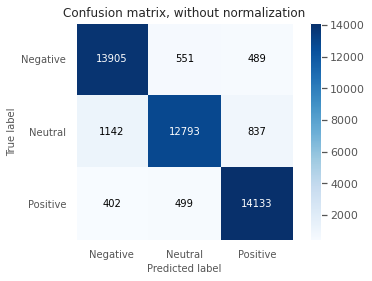

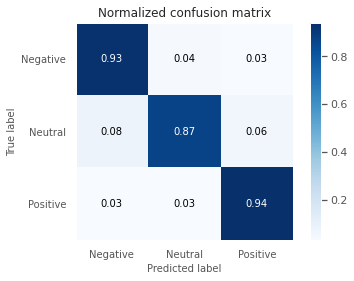

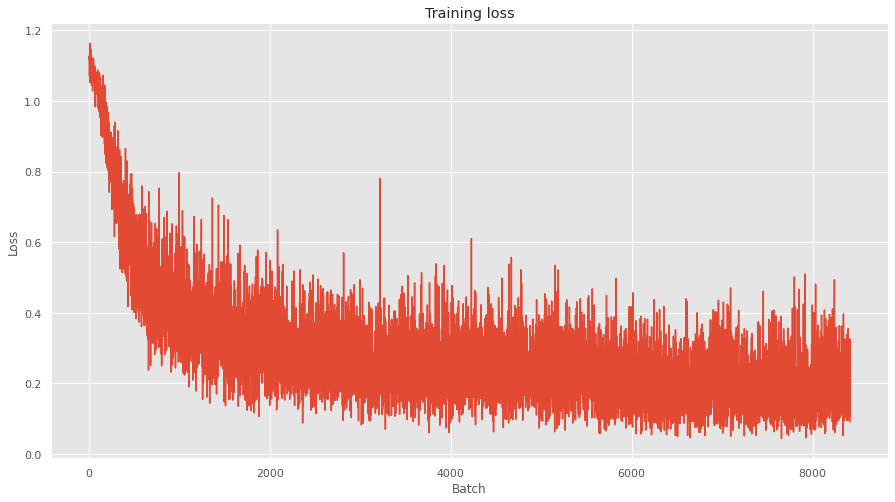

Accuracy: 0.91240419, f1: 0.91203216



In [92]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

acc, f1, y_test_pred, model_trained = \
        train_transformer(albert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

torch.save(model_trained.state_dict(), output_dir + 'fintweet_albert.dict')

In [93]:
result_df.loc['D2: ALBERT'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,NaN,NaN
B: Tfidf,NaN,NaN
C1: LSTM,0.8913,0.8913
C2: LSTM+GloVe,0.8907,0.8904
D1: BERT,0.9183,0.918
D2: ALBERT,0.9124,0.912


# Final Result

In [94]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = False
if disconnected:
    result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C: LSTM', 'D: LSTM+GloVe', 'E: BERT', 'F: ALBERT'])
    result_df.loc['A: Lexicon'] = (0.6522,0.4506)
    result_df.loc['B: Tfidf'] = (0.8145,0.7195)
    result_df.loc['C1: LSTM'] = (0.8185,0.7657)
    result_df.loc['C2: LSTM+GloVe'] = (0.8051,0.7415)
    result_df.loc['D1: BERT'] = (0.9493,0.9267)
    result_df.loc['D2: ALBERT'] = (0.9067,0.8849)


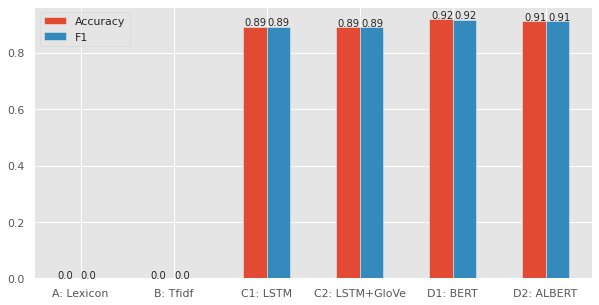

In [95]:
ax = result_df.plot.bar(rot=0, figsize=(10,5))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Save Data

In [96]:
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [97]:
# Save text data
save_data(train_df, 'tweet_result_df')

# Save state dict


# Extra - tweet stream

In [100]:
with open(tweet_dir + 'test_twits.json', 'r') as f:
    test_data = json.load(f)

def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

In [116]:
def predict(text, model, tokenizer):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """   
    text = preprocess(text)
    inputs = tokenizer(text, 
                   return_tensors="pt", 
                   padding='max_length',
                   max_length=96,
                   add_special_tokens=True,
                   truncation=True)

    outputs = model(**inputs)[0].detach()    
    pred = F.softmax(outputs, dim=1)
    
    return pred

In [103]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model.load_state_dict(torch.load(output_dir + 'fintweet_bert.dict'))
model.eval()
model.to("cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [109]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model, tokenizer)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'padding_side': 'right'} not recognized.


tensor([[0.0888, 0.7187, 0.1925]])

In [113]:
def score_twits(stream, model, tokenizer, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        if len(tokenizer.tokenize(preprocess(text))) < 10:
            continue
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, tokenizer)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'text': text, 'timestamp': twit['timestamp']}

In [114]:
# Select Universe
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, tokenizer, universe)

In [117]:
# Process
for i in range(10):
    print(next(score_stream))
    i+=1

{'symbol': '$AAPL', 'score': tensor([[0.0888, 0.7187, 0.1925]]), 'text': '$AAPL if it spikes $225, im selling my Calls. Not waiting for ER', 'timestamp': '2018-11-01T00:16:10Z'}
{'symbol': '$FB', 'score': tensor([[0.0888, 0.7187, 0.1925]]), 'text': 'Just to put things into perspective. $FB is back with $SPX since Nov 11, 2016', 'timestamp': '2018-11-01T00:17:32Z'}
{'symbol': '$AMZN', 'score': tensor([[0.0888, 0.7187, 0.1925]]), 'text': '$AMZN  \nS&amp;P 500 Futures - Dec 18  Shorts! Futures green in Thur Asia!', 'timestamp': '2018-11-01T00:19:42Z'}
{'symbol': '$AAPL', 'score': tensor([[0.0888, 0.7187, 0.1925]]), 'text': '$AAPL why would Apple, all of a sudden, have a bad quarter?', 'timestamp': '2018-11-01T00:19:51Z'}
{'symbol': '$AAPL', 'score': tensor([[0.0888, 0.7187, 0.1925]]), 'text': '$AAPL they always beat so relax bears, even if a miss buffet will buy all your shares', 'timestamp': '2018-11-01T00:20:23Z'}
{'symbol': '$AMZN', 'score': tensor([[0.0888, 0.7187, 0.1925]]), 'text': 